# Get things ready

In [ ]:
import importlib
import numpy as np
import numpy.typing as npt
from data_exploration.helpers import find_file, save
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import trackml_copy as outrunner_code
import trackml_2_solution_example as my_code

DO_EXPORT = True
DIRECTORY = my_code.DIRECTORY
SOLUTION_DIR = my_code.SOLUTION_DIR


Start from same point

In [67]:
event_name: str = "event000001001"
hits, cells, truth, particles = outrunner_code.get_event(event_name)
preload = True

outrunner_preds = np.load(SOLUTION_DIR + "my_%s.npy" % event_name, allow_pickle=True)
module_id = my_code.get_module_id(hits)
PATH_THR = 0.85

# Debug

Just run get_path

In [ ]:
hit_index = 0

mask = np.ones(len(hits))

# My path uses id, not index
my_path_0 = my_code.get_path(hit_index + 1, thr=PATH_THR, mask=mask, module_id=module_id,preds=outrunner_preds) -1 
outrunner_path_0 = outrunner_code.get_path2(hit_index, thr=PATH_THR, mask=mask, module_id=module_id, preds=outrunner_preds)

print("my path", my_path_0[:10])
print("outrunner path", outrunner_path_0[:10])
print("Instances not in agreement: ", np.where(my_path_0 != outrunner_path_0)[0])


Get n paths

In [ ]:
debug_limit = 1000 # generate only n paths
my_new_tracks_limited = my_code.get_all_paths(hits, thr= PATH_THR, preds=outrunner_preds, module_id=module_id, debug_limit=debug_limit)

outrunner_tracks_regenerated_limited: list[npt.NDArray] = outrunner_code.get_all_paths(hits, thr=PATH_THR, preds=outrunner_preds, module_id=module_id, debug_limit=debug_limit)

Print first n' tracks

In [ ]:
limit = debug_limit
print(f"{limit} my tracks", my_new_tracks_limited[:limit])
print(f"{limit} outrunner tracks", outrunner_tracks_regenerated_limited[:limit])

Compare tracks

In [ ]:
for test_track, verification_tracks in zip(my_new_tracks_limited[debug_limit], outrunner_tracks_regenerated_limited[debug_limit]):
    assert np.all(test_track-1 == verification_tracks), "Tracks are not equal"
print(f"All first {debug_limit} tracks are equal")

Compare first track

In [ ]:
# Subtrackt 1 from all ids to get indices
my_track_0 = my_new_tracks_limited[0]-1
outrunner_track_0 = outrunner_tracks_regenerated_limited[0]

print("my 1st tracks", my_track_0)
print("outrunner 1st tracks", outrunner_track_0)

Show outliers

In [ ]:
# print('isin' ,np.isin(my_track_0, outrunner_track_0, ))
overlap = np.where(np.isin(my_track_0, outrunner_track_0) == True)
outliers_1= np.where(np.isin(my_track_0, outrunner_track_0) == False)
outliers_2= np.where(np.isin(outrunner_track_0, my_track_0) == False)
print("overlap", overlap)
print("my hits not in outrunner", outliers_1)
print("outrunner hits not in mine", outliers_2)


Run just get_predict for both

In [ ]:
hit_index = 0
my_p_0 = my_code.retrieve_predict(hit_index+1, preds=outrunner_preds)
out_p_0 = outrunner_code.retrieve_predict(hit_index, preds=outrunner_preds)
print("my p", my_p_0[:15])
print("out p", out_p_0[:15])
print("Instances not in agreement: ", np.where(my_p_0 != out_p_0)[0])

In [ ]:

used_tracks = [outrunner_tracks, outrunner_tracks_regenerated][1]
limit = None

_make_my_scores = lambda: save(
    my_get_track_scores(used_tracks, 8, limit, index_shift=0),
    name="my_scores",
    tag=event_name,
    prefix=DIRECTORY,
    save=DO_EXPORT,
)
_make_outrunner_scores = lambda: save(
    outrunner_get_track_scores(used_tracks, 8, limit),
    name="outrunner_scores",
    tag=event_name,
    prefix=DIRECTORY,
    save=DO_EXPORT,
)

my_scores: npt.NDArray = find_file("my_scores", dir=DIRECTORY, fallback_func=_make_my_scores, force_fallback=not preload)  # type: ignore

outrunner_scores: npt.NDArray = find_file("outrunner_scores", dir=DIRECTORY, fallback_func=_make_outrunner_scores, force_fallback=not preload)  # type: ignore

limit = 5 if limit is None else limit
print("My scores: ", my_scores[:limit])
print("Outrunner scores: ", outrunner_scores[:limit])

pass

# Debug grand scale

In [ ]:
def verify_matrices(test_matrix: npt.NDArray | list[npt.NDArray], verification_matrix: npt.NDArray | list[npt.NDArray], limit: int | None = None):
    for i, (test_row, verification_row) in tqdm(enumerate(zip(test_matrix, verification_matrix)), total=min(len(test_matrix), len(verification_matrix))):
        if limit is not None and i >= limit:
            break

        tracks_equal = np.all(test_row == np.array(verification_row))
        if not tracks_equal:
            print("Rows are not equal")
            print("test row", test_row)
            print("good row", verification_row)
            print("Instances not in agreement: ", np.where(test_row!= verification_row)[0])
            raise ValueError("Rows are not equal")
    print(f"All first {i+1} rows are equal")
    return True

Define some functions that produce and then save result

In [ ]:
# Predict paths
_make_tracks = lambda: save(
    my_code.get_all_paths(hits, PATH_THR, module_id=module_id, preds=outrunner_preds, do_redraw=True),
    name="new_tracks_all",
    tag=event_name,
    prefix=DIRECTORY,
    save=DO_EXPORT
)


# calculate track's confidence
_make_scores = lambda: save(
    my_code.get_track_scores(tracks_all), name="new_scores", tag=event_name, prefix=DIRECTORY, save=DO_EXPORT
)

# Merge seeds to definite id's
_make_merged_tracks = lambda: save(
    my_code.run_merging(tracks_all, scores, preds=outrunner_preds, multi_stage=True, module_id=module_id,log_evaluations=True, truth=truth),
    name="merged_tracks",
    tag=event_name,
    prefix=DIRECTORY,
    save=DO_EXPORT,
)  # type: ignore

# Save submission
_make_submission = lambda: save(
    pd.DataFrame({"hit_id": hits.hit_id, "track_id": merged_tracks}),
    name="submission",
    tag=event_name,
    prefix=DIRECTORY,
    save=do_export,
)

In [ ]:
# Keep in mind result is not loaded if `preload` is False
print(f"Preload: {preload}")

Get tracks

In [ ]:
tracks_all: list[npt.NDArray] = find_file(f"new_tracks_all_{event_name}", dir=DIRECTORY, fallback_func=_make_tracks, force_fallback=not preload)  # type: ignore
outrunner_tracks: list[npt.NDArray] = find_file(f"outrunner_tracks_all", dir=DIRECTORY, extension='pkl')  # type: ignore

Verify

In [ ]:
test_tracks = tracks_all
verification_tracks = outrunner_tracks # outrunner_tracks_regenerated_limited

for i, (test_track, verification_tracks) in tqdm(enumerate(zip(test_tracks, verification_tracks)), total=min(len(test_tracks), len(verification_tracks))):
    verification_tracks = np.array(verification_tracks)
    test_track = np.array(test_track) - 1
    tracks_equal = np.all(test_track == np.array(verification_tracks))
    if not tracks_equal:
        print("Tracks are not equal")
        print("test track", test_track)
        print("good track", verification_tracks)
        print("Instances not in agreement: ", np.where(test_track!= verification_tracks)[0])
        raise ValueError("Tracks are not equal")
print(f"All first {i+1} tracks are equal") # type: ignore

Get scores

In [ ]:
my_scores: npt.NDArray = find_file(f"new_scores_{event_name}", dir=DIRECTORY, fallback_func=_make_scores, force_fallback=not preload)  # type: ignore
outrunner_scores: npt.NDArray = find_file(f"outrunner_scores_{event_name}", dir=DIRECTORY)  # type: ignore

Compare a few scores by eye

In [ ]:
limit=10
print(my_scores[:limit])
print(outrunner_scores[:limit])

Verify all scores

In [ ]:
print("Equal: ", verify_matrices(my_scores, outrunner_scores))

Get merged

In [ ]:
merged_tracks: npt.NDArray = find_file(f"merged_tracks_{event_name}", dir=DIRECTORY, fallback_func=_make_merged_tracks, force_fallback=not preload)  # type: ignore

# Show tracks

Make submission `DataFrame`

In [ ]:
submission = find_file(
    f"submission_{event_name}", dir=DIRECTORY, fallback_func=_make_submission, force_fallback=not preload
)  # type: ignore

Evaluate submission

In [ ]:
score = my_code.score_event(truth, submission)
print("TrackML Score:", score)
print("Fast score: ", my_code.score_event_fast(submission, truth))

Add our track_id to truth

In [ ]:
combined: pd.DataFrame = truth[["hit_id", "particle_id", "weight", "tx", "ty", "tz"]].merge(submission, how="left", on="hit_id") # type: ignore
# Group by unique combinations of track_id (our) and particle_id (truth); count number of hits overlapping
grouped: pd.DataFrame = (
    combined.groupby(["track_id", "particle_id"]).hit_id.count().to_frame("count_both").reset_index()
)
# Skip unallocated tracks (track_id == 0)
print(grouped[grouped['track_id'] > 0])

Select most likely related true `particle_id`

In [68]:
# Tracks are already ordered by score
track_id = 2000
possible_particle_ids: pd.DataFrame = grouped[grouped["track_id"] == track_id].sort_values(
    "count_both", ascending=False
)
most_likely_particle_id = int(possible_particle_ids.iloc[0]["particle_id"])

Select related truth and reconstructed data

In [69]:
reconstructed_track = combined[combined["track_id"] == track_id]
truth_track = combined[combined["particle_id"] == most_likely_particle_id]

In [70]:
print("Selected track ids: \n", reconstructed_track['hit_id'].values)

Selected track ids: 
 [16057 16142 22880 28339 32796 32805 56669 56671 61616 84044 88170]


In [71]:
print(reconstructed_track)

       hit_id         particle_id    weight        tx        ty        tz  \
16056   16057  373804060471459840  0.000015  -11.1025  -30.0988  -14.6261   
16141   16142  373804060471459840  0.000013  -11.5991  -31.3309  -15.2683   
22879   22880  373804060471459840  0.000011  -27.1902  -66.2327  -34.1936   
28338   28339  720579857389453312  0.000011  -43.6605 -107.1860  -59.7614   
32795   32796  720579857389453312  0.000010  -60.2661 -159.9040  -85.1312   
32804   32805  720579857389453312  0.000008  -60.7834 -161.7330  -86.0019   
56668   56669  720579857389453312  0.000006  -81.6449 -249.2440 -127.1460   
56670   56671  720579857389453312  0.000006  -80.4978 -243.1770 -124.3260   
61615   61616  337775057294065664  0.000005 -129.5230 -339.3000 -179.2640   
84043   84044  216178210952445952  0.000022 -416.2270 -711.3940 -413.3970   
88169   88170                   0  0.000000 -626.8210 -807.3630 -534.5600   

       track_id  
16056    2000.0  
16141    2000.0  
22879    2000.0  
283

In [83]:
reconstructed_weight_total = reconstructed_track["weight"].sum()
reconstructed_weight_overlap = reconstructed_track[reconstructed_track['particle_id'] == most_likely_particle_id]['weight'].sum()

truth_weight = truth_track["weight"].sum()

ratio = reconstructed_weight_overlap / truth_weight

print (f"Track {track_id} has total weight {reconstructed_weight_total}, vs {truth_weight} from particle {most_likely_particle_id}, ratio: {ratio:.4f}")

Track 2000 has total weight 0.00010692751, vs 0.00013007634 from particle 720579857389453312, ratio: 0.3125


Show fig

Text(0.5, 0.98, 'Track 2000 with particle id 720579857389453312 \n             weight ratio: 0.31             ')

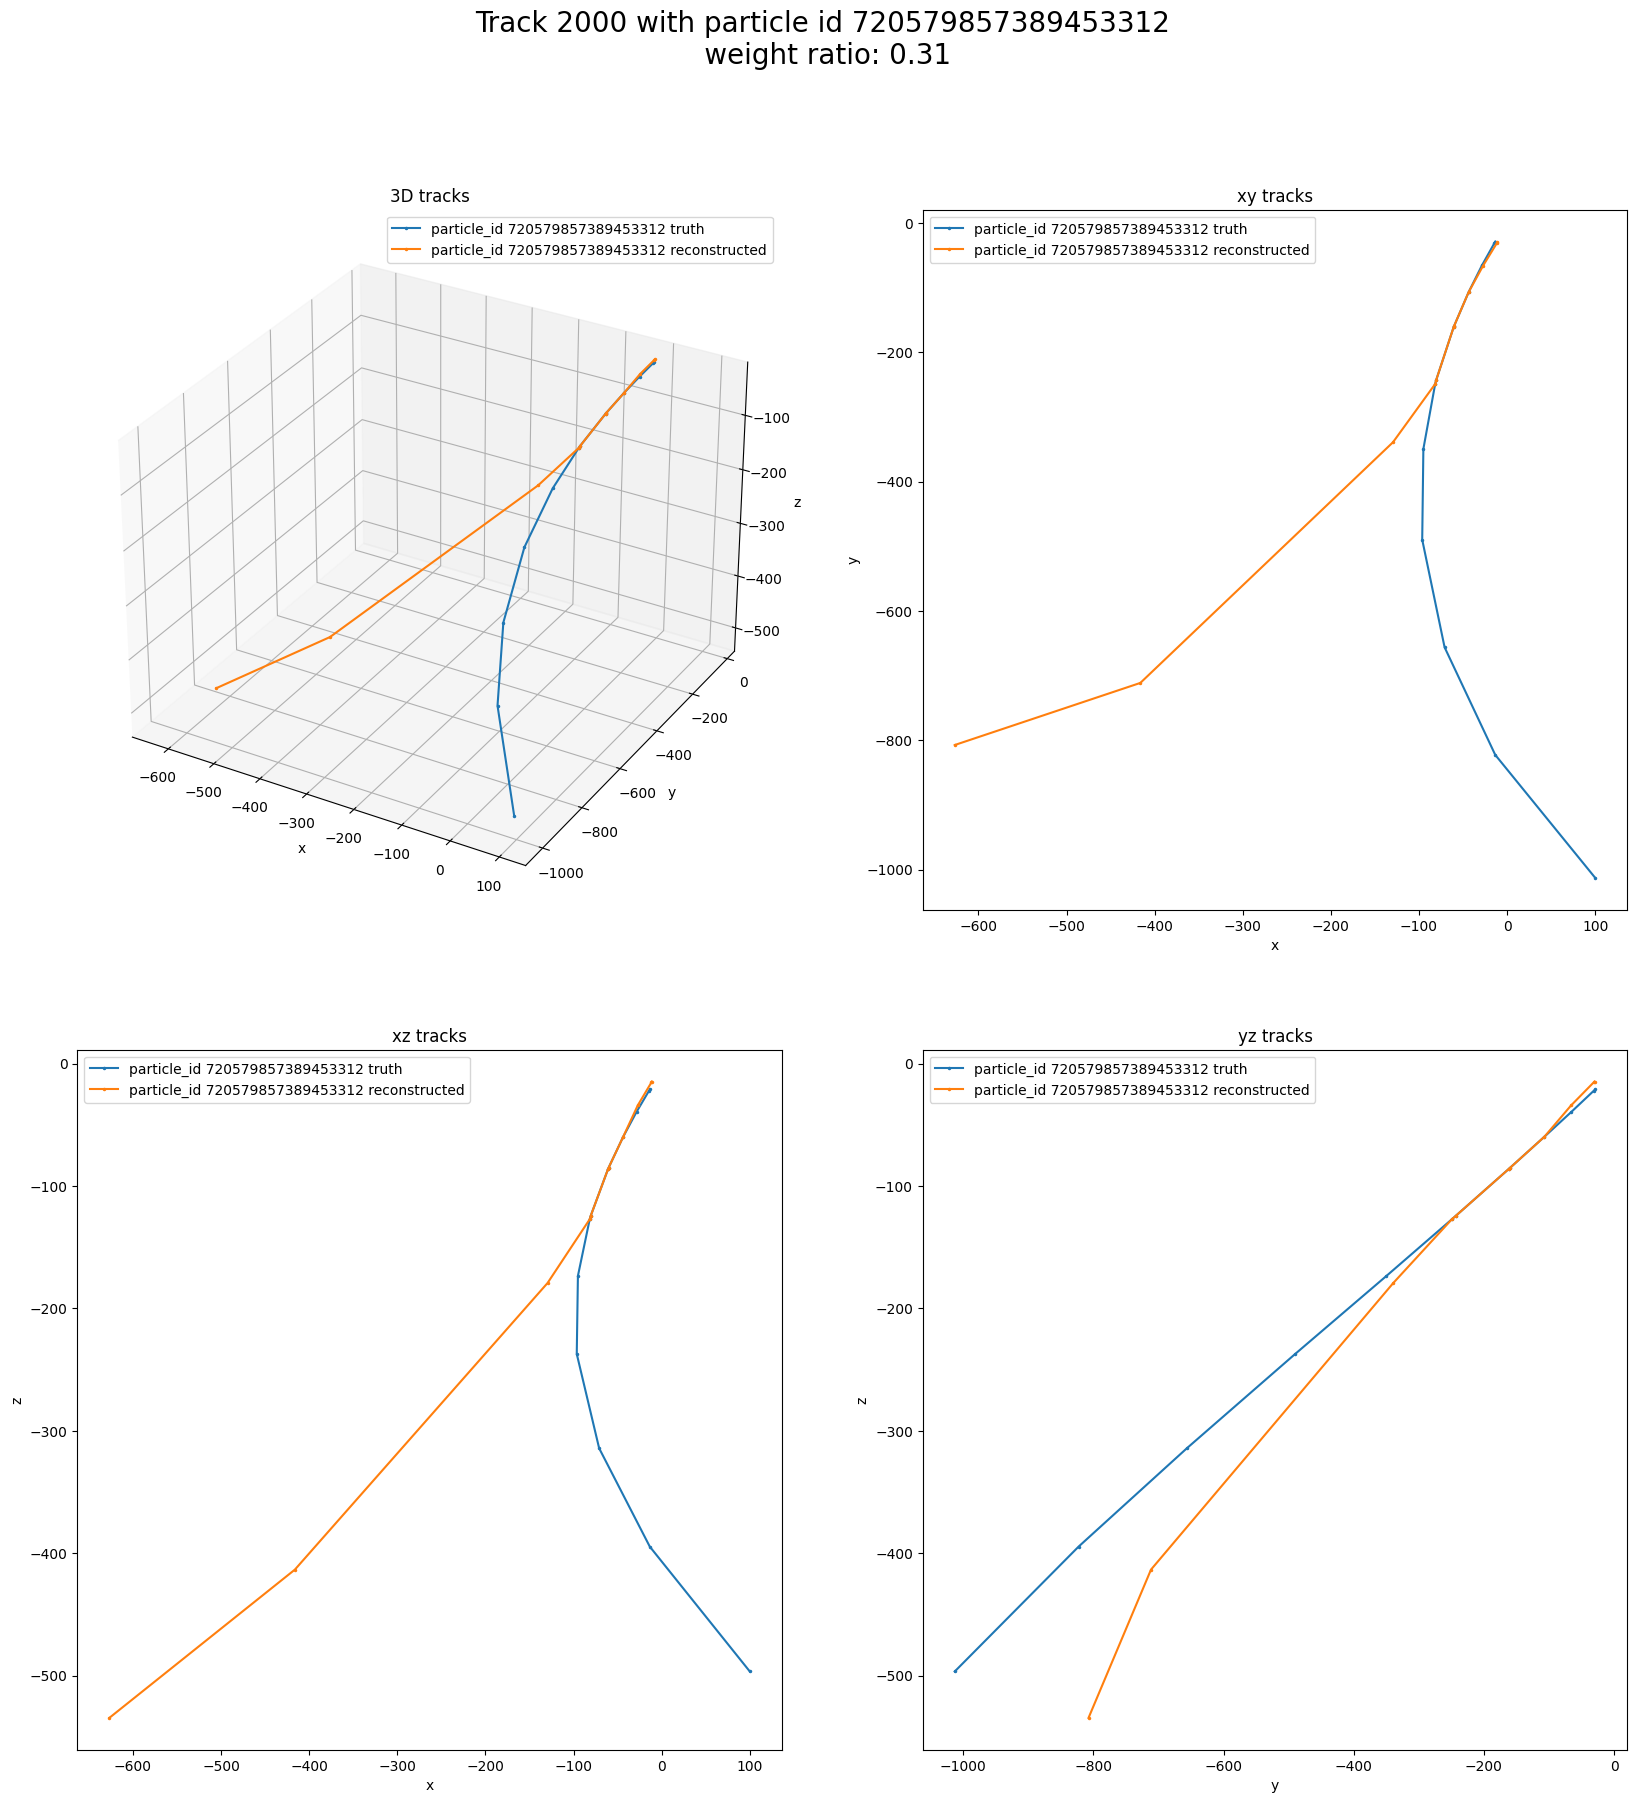

In [84]:
fig: plt.Figure = my_code.plot_prediction(truth_track, reconstructed_track, most_likely_particle_id, label_type="particle_id")
fig.suptitle(f"Track {track_id} with particle id {most_likely_particle_id} \n\
             weight ratio: {ratio:.2f}\
             ", fontsize=20)

Save fig

In [85]:
do_save_fig = False
if do_save_fig:
    fig.savefig(f"reconstructed_track_{track_id}_{event_name}.png", dpi=300)
    plt.close()